# Medical Image Analysis Project: Pneumonia Detection
## With Advanced Preprocessing Pipeline

### Overview
In this capstone project, you will apply the deep learning techniques learned in this course to a real-world medical imaging problem: **Pneumonia Detection from Chest X-Rays**.

Specifically, you will work with the **PneumoniaMNIST** dataset, a binary classification subset of the MedMNIST collection. Your goal is to build a robust classifier that distinguishes between 'Normal' and 'Pneumonia' cases.

Unlike previous tutorials where models were prescribed, **you interpret the data and choose the model architecture** best suited for the task. You will be evaluated not just on accuracy, but on your design choices, rigorous evaluation, and interpretability of results.

### Preprocessing Enhancements
This notebook integrates the advanced preprocessing pipeline from `preprocessing.py`, which includes:
- **Data Augmentation**: Random flips, rotations, affine transforms, color jitter
- **Normalization**: Dataset-specific mean/std normalization
- **Class Imbalance Handling**: Weighted sampling, Focal Loss
- **CLAHE**: Contrast Limited Adaptive Histogram Equalization
- **Mixup/CutMix**: Advanced regularization augmentations
- **Test-Time Augmentation (TTA)**: More robust test predictions

## 1. Setup and Data Loading
First, we install and load the necessary libraries. We rely on `medmnist` for data retrieval and `torch` for modeling.

In [12]:
# !pip install medmnist # Uncomment if running in Colab

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import medmnist
from medmnist import INFO, Evaluator
import matplotlib.pyplot as plt
import numpy as np

print(f"MedMNIST v{medmnist.__version__} @ {medmnist.__file__}")

MedMNIST v3.0.2 @ /home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/medmnist/__init__.py


### Import Preprocessing Pipeline
We import our custom preprocessing module that provides all the data processing utilities.

In [13]:
# Import the preprocessing pipeline
from preprocessing import (
    get_train_transform,
    get_val_transform,
    get_weighted_sampler,
    create_weighted_dataloader,
    get_class_weights,
    FocalLoss,
    WeightedCrossEntropyLoss,
    mixup_data,
    mixup_criterion,
    TestTimeAugmentation,
    print_preprocessing_info
)

# Print available preprocessing options
print_preprocessing_info()

Preprocessing Pipeline for PneumoniaMNIST

Available Transforms:
  - get_train_transform(use_augmentation=True)
  - get_val_transform()
  - get_train_transform_with_clahe(use_augmentation=True)

Class Imbalance Handling:
  - get_weighted_sampler(dataset)
  - create_weighted_dataloader(dataset, batch_size)
  - WeightedCrossEntropyLoss(class_weights)
  - FocalLoss(alpha=1.0, gamma=2.0)

Augmentation:
  - mixup_data(x, y, alpha=0.2)
  - cutmix_data(x, y, alpha=1.0)
  - TestTimeAugmentation(model, device, n_augments=8)

Radiomic Features:
  - extract_radiomic_features(img)
  - extract_batch_features(images)

Convenience Functions:
  - setup_preprocessing_pipeline(...)


### Data Understanding
We use **PneumoniaMNIST**, which contains cropped chest X-ray images. The task is binary classification: **0 (Normal)** vs **1 (Pneumonia)**.

In [14]:
data_flag = 'pneumoniamnist'
download = True

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# Use preprocessing pipeline transforms instead of basic transform
train_transform = get_train_transform(use_augmentation=True)
val_transform = get_val_transform()

print("Using Advanced Preprocessing Pipeline:")
print(f"  Train Transform: Augmentation + Normalization")
print(f"  Val/Test Transform: Normalization only")

# Load datasets with appropriate transforms
train_dataset = DataClass(split='train', transform=train_transform, download=download)
val_dataset = DataClass(split='val', transform=val_transform, download=download)
test_dataset = DataClass(split='test', transform=val_transform, download=download)

print(f"\nTrain samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Using Advanced Preprocessing Pipeline:
  Train Transform: Augmentation + Normalization
  Val/Test Transform: Normalization only

Train samples: 4708
Val samples: 524
Test samples: 624


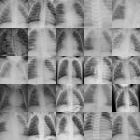

In [15]:
# Visualization of samples (need dataset without transform for visual)
viz_dataset = DataClass(split='train', transform=transforms.ToTensor(), download=False)
viz_dataset.montage(length=5)

### Class Distribution Analysis
Before proceeding, it is crucial to understand if our classes are balanced. Imbalanced datasets can lead to biased models that predict the majority class. Check the counts below.

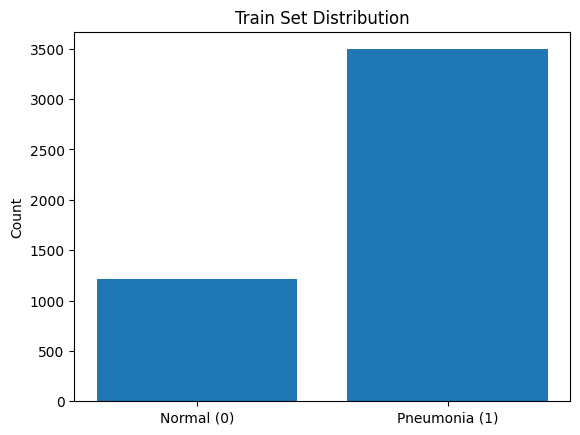

Counts: {'Normal': 1214, 'Pneumonia': 3494}

Class Imbalance Ratio: 2.88x more Pneumonia samples


In [16]:
# Analyze Class Distribution
def plot_class_distribution(dataset, title='Class Distribution'):
    targets = [y for _, y in dataset]
    targets = np.array(targets).squeeze()
    unique, counts = np.unique(targets, return_counts=True)
    plt.bar(unique, counts)
    plt.xticks(unique, ['Normal (0)', 'Pneumonia (1)'])
    plt.title(title)
    plt.ylabel('Count')
    plt.show()
    print(f"Counts: {dict(zip(['Normal', 'Pneumonia'], counts))}")
    print(f"\nClass Imbalance Ratio: {counts[1]/counts[0]:.2f}x more Pneumonia samples")

plot_class_distribution(train_dataset, 'Train Set Distribution')

## 2. Project Requirements

You are required to complete the following tasks to structure your project. Please document your process clearly in markdown cells alongside your code.

### 1. Define the Problem Statement
- Clearly state the medical problem you are solving (Pneumonia Detection).
- Explain why this is important and what the clinical impact of an automated solution could be.
- Describe the dataset characteristics (size, class balance, image type).

### 2. Choose an Architecture / Approach
- Select a modeling approach. You may choose:
    - One of the architectures explored in `Building_Models.ipynb` (e.g., Simple CNN, Radiomics-based RF, Contrastive Learning).
    - An alternative architecture (e.g., ResNet, DenseNet, Vision Transformer) if you wish to explore further.
- **Justify your choice**: Why is this model suitable for this specific task and dataset?

### 3. Hyperparameter Tuning
- Experiment with key hyperparameters to optimize performance.
- Consider tuning: Learning rate, Batch size, Number of epochs, Optimizer type (Adam vs SGD), Dropout rate, etc.
- Document your tuning process and the final set of hyperparameters selected.

### 4. Training Analysis
- Implement a training loop that tracks performance on both Training and Validation sets.
- **Produce a Training Loss Curve**: Plot training and validation loss over epochs to diagnose overfitting or underfitting.

### 5. Evaluation and Metrics
- Evaluate your best model on the **Test Set**.
- **Produce an ROC Curve**: Plot the Receiver Operating Characteristic curve.
- Report key metrics:
    - **AUC (Area Under Curve)**
    - **F1-Score**
    - **Sensitivity (Recall)** and **Specificity**

### 6. Extensions, Limitations, and Implications
- **Extensions**: How could this model be improved further? (e.g., more data, ensemble methods, external validation).
- **Limitations**: What are the current weaknesses of your solution? (e.g., class imbalance handling, robustness to noise, generalization).
- **Implications**: Discuss the ethical and practical implications of deploying this AI model in a real clinical setting (e.g., bias, explainability, doctor-AI collaboration).

## 3. Student Workspace
Implement your solution below.

In [17]:
# Your code starts here
# Good luck!

## Prepare Dataset with Preprocessing Pipeline

In [18]:
# ========================================
# 2. Prepare Dataset with Preprocessing
# ========================================

# Use the PneumoniaMNIST dataset (already binary: 0=Normal, 1=Pneumonia)
from medmnist import PneumoniaMNIST

# Use preprocessing pipeline transforms
train_transform = get_train_transform(use_augmentation=True)
val_transform = get_val_transform()

# Load PneumoniaMNIST datasets with preprocessing transforms
train_dataset = PneumoniaMNIST(split='train', transform=train_transform, download=True)
val_dataset = PneumoniaMNIST(split='val', transform=val_transform, download=True)
test_dataset = PneumoniaMNIST(split='test', transform=val_transform, download=True)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Calculate class weights for weighted loss
class_weights = get_class_weights(train_dataset)
print(f"\nClass weights: {class_weights}")

# Create weighted sampler for class-balanced training
weighted_sampler = get_weighted_sampler(train_dataset)

# DataLoaders - using weighted sampling for training
BATCH_SIZE = 64

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    sampler=weighted_sampler,  # Weighted sampling for class balance
    num_workers=0
)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print("\n✅ Datasets and loaders ready with:")
print("  - Data augmentation (flips, rotations, affine, color jitter)")
print("  - Weighted sampling for class balance")
print("  - Normalization (mean=0.5, std=0.5)")

Train samples: 4708
Val samples: 524
Test samples: 624



Class weights: tensor([1.9390, 0.6737])

✅ Datasets and loaders ready with:
  - Data augmentation (flips, rotations, affine, color jitter)
  - Weighted sampling for class balance
  - Normalization (mean=0.5, std=0.5)


Using device: cuda
Using FocalLoss for handling class imbalance

🚀 Training Small CNN with Preprocessing Pipeline...
Epoch 1/5 | Loss: 0.1540
Epoch 2/5 | Loss: 0.1237
Epoch 3/5 | Loss: 0.1163
Epoch 4/5 | Loss: 0.1059
Epoch 5/5 | Loss: 0.1014

📈 Pneumonia Detection - Small 3-Layer CNN Results (With Preprocessing):
              precision    recall  f1-score   support

      Normal     0.7889    0.9103    0.8452       234
   Pneumonia     0.9407    0.8538    0.8952       390

    accuracy                         0.8750       624
   macro avg     0.8648    0.8821    0.8702       624
weighted avg     0.8838    0.8750    0.8764       624

ROC AUC: 0.9430
Precision: 0.9407
Recall (Sensitivity): 0.8538
Specificity: 0.9103
F1 Score: 0.8952


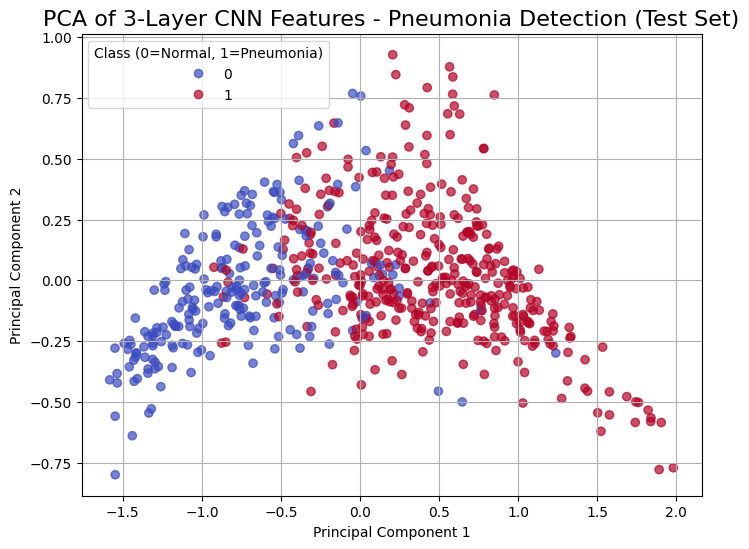

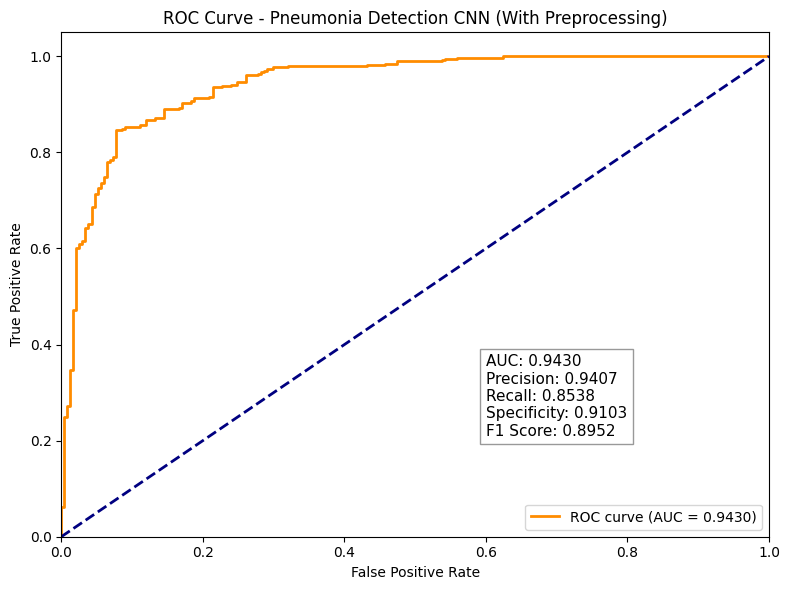

In [19]:
# ========================================
# 4. Small 3-Layer CNN Classifier with Preprocessing
# ========================================

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Import metrics
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, classification_report, roc_curve
from sklearn.decomposition import PCA

# Define model (1 input channel for grayscale X-ray images)
class SmallCNN(nn.Module):
    def __init__(self):
        super(SmallCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # 1 channel for grayscale
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SmallCNN().to(device)

# Training setup - using FocalLoss for class imbalance
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = FocalLoss(alpha=1.0, gamma=2.0)  # Using FocalLoss from preprocessing

print("Using FocalLoss for handling class imbalance")

# Train loop with optional Mixup
def train_model(model, loader, optimizer, criterion, epochs=5, use_mixup=False, mixup_alpha=0.2):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.squeeze().long().to(device)
            
            optimizer.zero_grad()
            
            if use_mixup:
                # Apply Mixup augmentation
                mixed_imgs, labels_a, labels_b, lam = mixup_data(imgs, labels, alpha=mixup_alpha)
                outputs = model(mixed_imgs)
                loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
            else:
                outputs = model(imgs)
                loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} | Loss: {running_loss/len(loader):.4f}")

print("\n🚀 Training Small CNN with Preprocessing Pipeline...")
train_model(model, train_loader, optimizer, criterion, epochs=5, use_mixup=True)

# Evaluation
def evaluate_model(model, loader):
    model.eval()
    all_preds, all_labels, all_probs, all_features = [], [], [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.squeeze().numpy()  # Squeeze labels to 1D
            outputs = model(imgs)
            probs = torch.softmax(outputs, dim=1)[:,1]  # Probabilities for class 1 (Pneumonia)
            preds = torch.argmax(outputs, dim=1)

            all_preds.append(preds.cpu().numpy())
            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels)
            all_features.append(model.features(imgs).view(imgs.size(0), -1).cpu().numpy())

    return (np.concatenate(all_labels),
            np.concatenate(all_preds),
            np.concatenate(all_probs),
            np.vstack(all_features))

y_true, y_pred, y_probs, test_features = evaluate_model(model, test_loader)

# Metrics
roc_auc = roc_auc_score(y_true, y_probs)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Calculate specificity
tn = np.sum((y_true == 0) & (y_pred == 0))
fp = np.sum((y_true == 0) & (y_pred == 1))
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

print("\n📈 Pneumonia Detection - Small 3-Layer CNN Results (With Preprocessing):")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia'], digits=4))
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score: {f1:.4f}")

# PCA Visualization
pca = PCA(n_components=2)
test_features_pca = pca.fit_transform(test_features)

plt.figure(figsize=(8,6))
scatter = plt.scatter(test_features_pca[:,0], test_features_pca[:,1], c=y_true, cmap='coolwarm', alpha=0.7)
plt.title('PCA of 3-Layer CNN Features - Pneumonia Detection (Test Set)', fontsize=16)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(*scatter.legend_elements(), title="Class (0=Normal, 1=Pneumonia)")
plt.grid(True)
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Pneumonia Detection CNN (With Preprocessing)')
plt.legend(loc='lower right')

# Add metrics box
metrics_text = (
    f"AUC: {roc_auc:.4f}\n"
    f"Precision: {precision:.4f}\n"
    f"Recall: {recall:.4f}\n"
    f"Specificity: {specificity:.4f}\n"
    f"F1 Score: {f1:.4f}"
)
plt.text(0.6, 0.2, metrics_text, fontsize=11, 
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'),
         transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

Using device: cuda
MedNet Parameters: 3,277,046

🚀 Training MedNet with Advanced Preprocessing...
  - Using weighted sampling for class balance
  - Using FocalLoss for class imbalance
  - Using Mixup augmentation
  - Using data augmentation (flips, rotations, etc.)

Epoch 1/20 | Train Loss: 0.1353 | Val Loss: 0.1050 | LR: 0.000298


Epoch 2/20 | Train Loss: 0.1018 | Val Loss: 0.1070 | LR: 0.000293
Epoch 3/20 | Train Loss: 0.1056 | Val Loss: 0.0823 | LR: 0.000284
Epoch 4/20 | Train Loss: 0.0903 | Val Loss: 0.0685 | LR: 0.000271
Epoch 5/20 | Train Loss: 0.0806 | Val Loss: 0.0982 | LR: 0.000256
Epoch 6/20 | Train Loss: 0.0882 | Val Loss: 0.1016 | LR: 0.000238
Epoch 7/20 | Train Loss: 0.0871 | Val Loss: 0.0770 | LR: 0.000218
Epoch 8/20 | Train Loss: 0.0885 | Val Loss: 0.0787 | LR: 0.000197
Epoch 9/20 | Train Loss: 0.0838 | Val Loss: 0.0755 | LR: 0.000174
Epoch 10/20 | Train Loss: 0.0840 | Val Loss: 0.0971 | LR: 0.000150
Epoch 11/20 | Train Loss: 0.0815 | Val Loss: 0.0727 | LR: 0.000127
Epoch 12/20 | Train Loss: 0.0800 | Val Loss: 0.0694 | LR: 0.000104
Epoch 13/20 | Train Loss: 0.0848 | Val Loss: 0.0686 | LR: 0.000083
Epoch 14/20 | Train Loss: 0.0815 | Val Loss: 0.0816 | LR: 0.000063
Epoch 15/20 | Train Loss: 0.0808 | Val Loss: 0.0696 | LR: 0.000045
Epoch 16/20 | Train Loss: 0.0835 | Val Loss: 0.0675 | LR: 0.000030
Epo

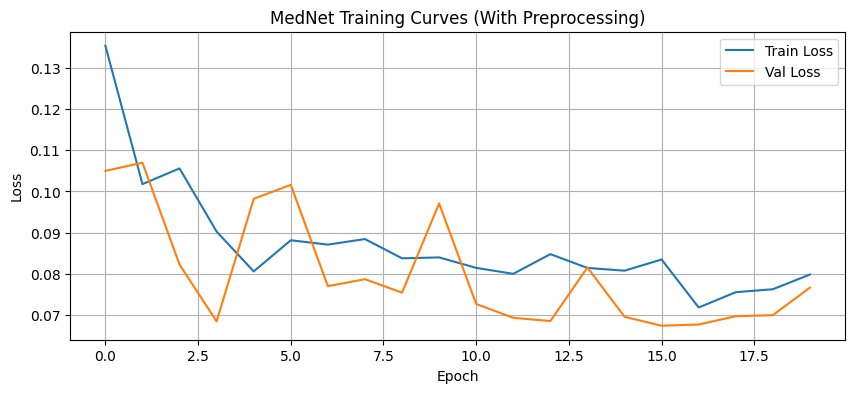


📈 Pneumonia Detection - MedNet Results (With Preprocessing):
              precision    recall  f1-score   support

      Normal     0.8051    0.9359    0.8656       234
   Pneumonia     0.9574    0.8641    0.9084       390

    accuracy                         0.8910       624
   macro avg     0.8813    0.9000    0.8870       624
weighted avg     0.9003    0.8910    0.8923       624

ROC AUC: 0.9632
Precision: 0.9574
Recall (Sensitivity): 0.8641
Specificity: 0.9359
F1 Score: 0.9084


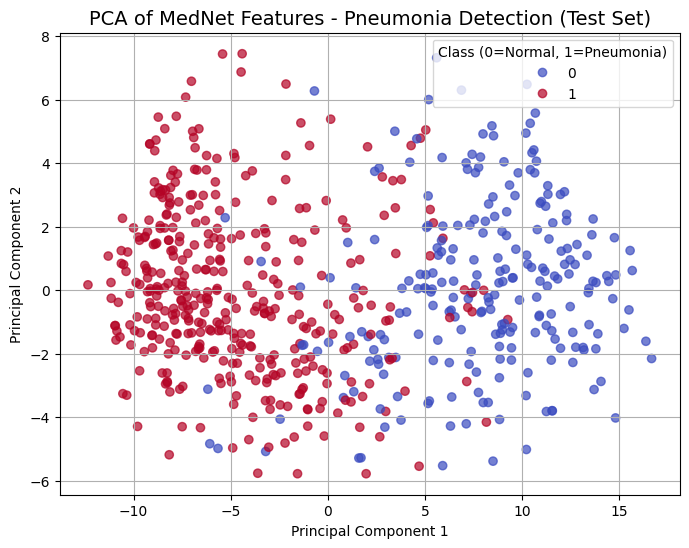

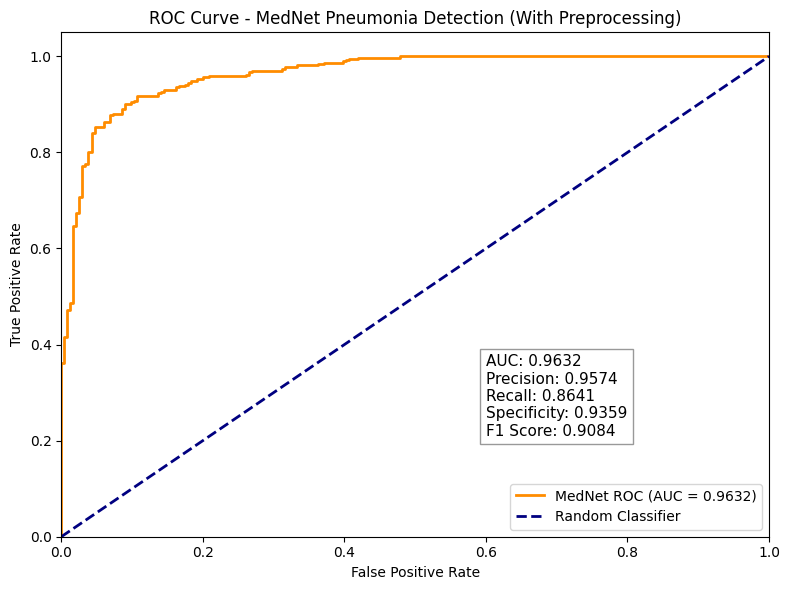

In [20]:
# ========================================
# 5. MedNet Classifier with Preprocessing
# ========================================
# MedNet: Lightweight Attention-Augmented CNN for Medical Image Classification
# Paper: https://www.nature.com/articles/s41598-025-25857-w

# Import the MedNet model and count_parameters from models.py
from models import MedNet, count_parameters

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create MedNet model (1 input channel for grayscale, 2 classes for binary classification)
mednet_model = MedNet(
    in_channels=1,    # Grayscale chest X-rays
    num_classes=2,    # Normal vs Pneumonia
    dropout=0.4
).to(device)

print(f"MedNet Parameters: {count_parameters(mednet_model):,}")

# Training setup - using FocalLoss from preprocessing module
optimizer_mednet = torch.optim.AdamW(
    mednet_model.parameters(),
    lr=3e-4,
    weight_decay=1e-4
)

# Use FocalLoss from preprocessing module for class imbalance
criterion_mednet = FocalLoss(alpha=1, gamma=2)

# Learning rate scheduler (Cosine Annealing as per paper)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer_mednet,
    T_max=20,
    eta_min=1e-6
)

# Training loop with validation tracking and optional Mixup
def train_mednet(model, train_loader, val_loader, optimizer, criterion, scheduler, epochs=20, use_mixup=True):
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device)
            labels = labels.squeeze().long().to(device)
            
            optimizer.zero_grad()
            
            if use_mixup:
                # Apply Mixup augmentation
                mixed_imgs, labels_a, labels_b, lam = mixup_data(imgs, labels, alpha=0.2)
                outputs = model(mixed_imgs)
                loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
            else:
                outputs = model(imgs)
                loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs = imgs.to(device)
                labels = labels.squeeze().long().to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        
        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)
        
        # Update learning rate
        scheduler.step()
        
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")
    
    return train_losses, val_losses

# Train MedNet
print("\n🚀 Training MedNet with Advanced Preprocessing...")
print("  - Using weighted sampling for class balance")
print("  - Using FocalLoss for class imbalance")
print("  - Using Mixup augmentation")
print("  - Using data augmentation (flips, rotations, etc.)\n")

train_losses, val_losses = train_mednet(
    mednet_model, train_loader, val_loader,
    optimizer_mednet, criterion_mednet, scheduler,
    epochs=20, use_mixup=True
)

# Plot training curves
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MedNet Training Curves (With Preprocessing)')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation function for MedNet
def evaluate_mednet(model, loader):
    model.eval()
    all_preds, all_labels, all_probs, all_features = [], [], [], []
    
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.squeeze().numpy()
            
            outputs = model(imgs)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Probability for Pneumonia class
            preds = torch.argmax(outputs, dim=1)
            
            # Get features for visualization
            features = model.get_features(imgs)
            
            all_preds.append(preds.cpu().numpy())
            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels)
            all_features.append(features.cpu().numpy())
    
    return (np.concatenate(all_labels),
            np.concatenate(all_preds),
            np.concatenate(all_probs),
            np.vstack(all_features))

# Evaluate on test set
y_true_mednet, y_pred_mednet, y_probs_mednet, test_features_mednet = evaluate_mednet(mednet_model, test_loader)

# Compute metrics
roc_auc_mednet = roc_auc_score(y_true_mednet, y_probs_mednet)
precision_mednet = precision_score(y_true_mednet, y_pred_mednet)
recall_mednet = recall_score(y_true_mednet, y_pred_mednet)
f1_mednet = f1_score(y_true_mednet, y_pred_mednet)

# Calculate specificity
tn = np.sum((y_true_mednet == 0) & (y_pred_mednet == 0))
fp = np.sum((y_true_mednet == 0) & (y_pred_mednet == 1))
specificity_mednet = tn / (tn + fp) if (tn + fp) > 0 else 0

print("\n📈 Pneumonia Detection - MedNet Results (With Preprocessing):")
print(classification_report(y_true_mednet, y_pred_mednet, target_names=['Normal', 'Pneumonia'], digits=4))
print(f"ROC AUC: {roc_auc_mednet:.4f}")
print(f"Precision: {precision_mednet:.4f}")
print(f"Recall (Sensitivity): {recall_mednet:.4f}")
print(f"Specificity: {specificity_mednet:.4f}")
print(f"F1 Score: {f1_mednet:.4f}")

# PCA Visualization of MedNet features
pca_mednet = PCA(n_components=2)
test_features_pca_mednet = pca_mednet.fit_transform(test_features_mednet)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(test_features_pca_mednet[:, 0], test_features_pca_mednet[:, 1],
                      c=y_true_mednet, cmap='coolwarm', alpha=0.7)
plt.title('PCA of MedNet Features - Pneumonia Detection (Test Set)', fontsize=14)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(*scatter.legend_elements(), title="Class (0=Normal, 1=Pneumonia)")
plt.grid(True)
plt.show()

# ROC Curve
fpr_mednet, tpr_mednet, _ = roc_curve(y_true_mednet, y_probs_mednet)

plt.figure(figsize=(8, 6))
plt.plot(fpr_mednet, tpr_mednet, color='darkorange', lw=2, label=f'MedNet ROC (AUC = {roc_auc_mednet:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - MedNet Pneumonia Detection (With Preprocessing)')
plt.legend(loc='lower right')

# Add metrics box
metrics_text = (
    f"AUC: {roc_auc_mednet:.4f}\n"
    f"Precision: {precision_mednet:.4f}\n"
    f"Recall: {recall_mednet:.4f}\n"
    f"Specificity: {specificity_mednet:.4f}\n"
    f"F1 Score: {f1_mednet:.4f}"
)
plt.text(0.6, 0.2, metrics_text, fontsize=11, 
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'),
         transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

## Hyperparameter Tuning with Optuna

We use **Optuna** to systematically search for the best hyperparameters for the MedNet model. The following hyperparameters are tuned:

- **Learning rate** (log scale: 1e-5 to 1e-2)
- **Batch size** (32, 64, 128)
- **Dropout** (0.2 to 0.6)
- **Weight decay** (log scale: 1e-6 to 1e-3)
- **Optimizer** (Adam vs AdamW)
- **Focal Loss alpha** (0.5 to 2.0) — controls class weighting
- **Focal Loss gamma** (1.0 to 3.0) — controls focus on hard examples
- **Mixup usage** (on/off) and **Mixup alpha** (0.1 to 0.4)

The objective is to **maximize validation AUC** over 10 training epochs per trial, with early pruning of unpromising trials.

In [22]:
# ========================================
# HYPERPARAMETER TUNING WITH OPTUNA
# ========================================

!pip install optuna -q
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, roc_curve
from models import MedNet, FocalLoss, count_parameters

print("=" * 60)
print("HYPERPARAMETER TUNING WITH OPTUNA (using MedNet)")
print("=" * 60)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def objective(trial):
    """
    Objective function for hyperparameter optimization.
    Optuna will try to maximize validation AUC.
    """

    # Suggest hyperparameters
    lr = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    dropout = trial.suggest_float('dropout', 0.2, 0.6)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'AdamW'])

    # Focal Loss hyperparameters
    focal_alpha = trial.suggest_float('focal_alpha', 0.5, 2.0)
    focal_gamma = trial.suggest_float('focal_gamma', 1.0, 3.0)

    # Mixup hyperparameters
    use_mixup = trial.suggest_categorical('use_mixup', [True, False])
    mixup_alpha = trial.suggest_float('mixup_alpha', 0.1, 0.4) if use_mixup else 0.0

    # Create data loaders with suggested batch size
    # Use weighted sampler for class balance (same as main training)
    trial_train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=get_weighted_sampler(train_dataset),
        num_workers=0
    )
    trial_val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0
    )

    # Initialize MedNet model with suggested dropout
    model = MedNet(in_channels=1, num_classes=2, dropout=dropout).to(device)

    # Initialize optimizer
    if optimizer_name == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Cosine Annealing scheduler (as used in main training)
    num_epochs = 5
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=num_epochs, eta_min=1e-6
    )

    # Initialize loss function
    criterion = FocalLoss(alpha=focal_alpha, gamma=focal_gamma)

    # Training loop
    best_val_auc = 0.0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        for imgs, labels in trial_train_loader:
            imgs = imgs.to(device)
            labels = labels.squeeze().long().to(device)

            optimizer.zero_grad()

            if use_mixup:
                mixed_imgs, labels_a, labels_b, lam = mixup_data(imgs, labels, alpha=mixup_alpha)
                outputs = model(mixed_imgs)
                loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
            else:
                outputs = model(imgs)
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

        scheduler.step()

        # Validation phase
        model.eval()
        val_probs = []
        val_labels = []

        with torch.no_grad():
            for imgs, labels in trial_val_loader:
                imgs = imgs.to(device)
                labels = labels.squeeze()

                outputs = model(imgs)
                probs = torch.softmax(outputs, dim=1)[:, 1]

                val_probs.extend(probs.cpu().numpy())
                val_labels.extend(labels.numpy())

        # Calculate validation AUC
        val_auc = roc_auc_score(val_labels, val_probs)

        # Track best validation AUC
        if val_auc > best_val_auc:
            best_val_auc = val_auc

        # Report intermediate value for pruning
        trial.report(val_auc, epoch)

        # Prune trial if it's not promising
        if trial.should_prune():
            raise optuna.TrialPruned()

    return best_val_auc


# Create Optuna study
print("\nStarting hyperparameter search...")
print("This may take 15-30 minutes depending on your hardware.\n")

study = optuna.create_study(
    direction='maximize',  # Maximize validation AUC
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=3),
    sampler=optuna.samplers.TPESampler(seed=42)
)

# Run optimization
study.optimize(objective, n_trials=10, timeout=1800)  # 30 trials or 30 minutes max

print("\n" + "=" * 60)
print("HYPERPARAMETER TUNING RESULTS")
print("=" * 60)

# Best trial results
print(f"\nBest Trial: #{study.best_trial.number}")
print(f"Best Validation AUC: {study.best_value:.4f}")
print(f"\nBest Hyperparameters:")
for key, value in study.best_params.items():
    print(f"  {key:20s}: {value}")

[I 2026-02-05 20:58:05,954] A new study created in memory with name: no-name-1dd44eeb-1eb4-43c6-b0d9-fffbfa1b8cd2


HYPERPARAMETER TUNING WITH OPTUNA (using MedNet)

Starting hyperparameter search...
This may take 15-30 minutes depending on your hardware.



[I 2026-02-05 20:59:09,425] Trial 0 finished with value: 0.9823479005998286 and parameters: {'learning_rate': 0.0001329291894316216, 'batch_size': 32, 'dropout': 0.2624074561769746, 'weight_decay': 2.9375384576328313e-06, 'optimizer': 'AdamW', 'focal_alpha': 1.4016725176148133, 'focal_gamma': 2.416145155592091, 'use_mixup': False}. Best is trial 0 with value: 0.9823479005998286.
[I 2026-02-05 21:00:13,024] Trial 1 finished with value: 0.9910882604970008 and parameters: {'learning_rate': 0.00314288089084011, 'batch_size': 32, 'dropout': 0.3216968971838151, 'weight_decay': 3.752055855124284e-05, 'optimizer': 'Adam', 'focal_alpha': 1.4177793420835691, 'focal_gamma': 1.2789877213040837, 'use_mixup': False}. Best is trial 1 with value: 0.9910882604970008.
[I 2026-02-05 21:01:16,821] Trial 2 finished with value: 0.9833952204132153 and parameters: {'learning_rate': 0.00023345864076016249, 'batch_size': 32, 'dropout': 0.43696582754481694, 'weight_decay': 1.3783237455007196e-06, 'optimizer': 'A


HYPERPARAMETER TUNING RESULTS

Best Trial: #7
Best Validation AUC: 0.9916

Best Hyperparameters:
  learning_rate       : 0.0015446089075047066
  batch_size          : 64
  dropout             : 0.2478376983753207
  weight_decay        : 0.00013795402040204168
  optimizer           : Adam
  focal_alpha         : 1.6564507699318414
  focal_gamma         : 1.9875911927287815
  use_mixup           : True
  mixup_alpha         : 0.10762573802322856


In [23]:
# ========================================
# VISUALIZATION OF TUNING RESULTS
# ========================================

# 1. Optimization History
fig1 = plot_optimization_history(study)
fig1.update_layout(
    title="Hyperparameter Optimization History",
    xaxis_title="Trial Number",
    yaxis_title="Validation AUC",
    font=dict(size=12),
    width=900,
    height=500
)
fig1.show()

# 2. Parameter Importances
fig2 = plot_param_importances(study)
fig2.update_layout(
    title="Hyperparameter Importance",
    xaxis_title="Importance",
    font=dict(size=12),
    width=900,
    height=500
)
fig2.show()

# 3. Parallel Coordinate Plot
fig3 = optuna.visualization.plot_parallel_coordinate(
    study,
    params=['learning_rate', 'batch_size', 'dropout', 'weight_decay']
)
fig3.update_layout(
    title="Parallel Coordinate Plot (Key Hyperparameters)",
    font=dict(size=12),
    width=900,
    height=500
)
fig3.show()

# 4. Top 5 trials summary table
trials_df = study.trials_dataframe()
trials_df = trials_df.sort_values('value', ascending=False)

print("\nTop 5 Trials:")
display_cols = ['number', 'value']
for col in trials_df.columns:
    if col.startswith('params_'):
        display_cols.append(col)
print(trials_df[display_cols].head())


Top 5 Trials:
   number     value  params_batch_size  params_dropout  params_focal_alpha  \
7       7  0.991621                 64        0.247838            1.656451   
1       1  0.991088                 32        0.321697            1.417779   
6       6  0.990003                 64        0.343386            0.996347   
2       2  0.983395                 32        0.436966            0.597577   
0       0  0.982348                 32        0.262407            1.401673   

   params_focal_gamma  params_learning_rate  params_mixup_alpha  \
7            1.987591              0.001545            0.107626   
1            1.278988              0.003143                 NaN   
6            1.127117              0.001320                 NaN   
2            2.897771              0.000233            0.191384   
0            2.416145              0.000133                 NaN   

  params_optimizer  params_use_mixup  params_weight_decay  
7             Adam              True             0.00

RETRAINING MedNet WITH BEST HYPERPARAMETERS

Using best hyperparameters from Trial #7:
  learning_rate: 0.0015446089075047066
  batch_size: 64
  dropout: 0.2478376983753207
  weight_decay: 0.00013795402040204168
  optimizer: Adam
  focal_alpha: 1.6564507699318414
  focal_gamma: 1.9875911927287815
  use_mixup: True
  mixup_alpha: 0.10762573802322856

MedNet Parameters: 3,277,046

Training for 20 epochs...
  Mixup: ON (alpha=0.11)

Epoch  1/20 | Train Loss: 0.2221 | Val Loss: 0.0878 | Val AUC: 0.9792 | LR: 0.001535
Epoch  2/20 | Train Loss: 0.1395 | Val Loss: 0.1002 | Val AUC: 0.9826 | LR: 0.001507
Epoch  3/20 | Train Loss: 0.1421 | Val Loss: 0.1951 | Val AUC: 0.9822 | LR: 0.001460
Epoch  4/20 | Train Loss: 0.1316 | Val Loss: 0.0984 | Val AUC: 0.9885 | LR: 0.001397
Epoch  5/20 | Train Loss: 0.1406 | Val Loss: 0.2337 | Val AUC: 0.9873 | LR: 0.001319
Epoch  6/20 | Train Loss: 0.1119 | Val Loss: 0.0832 | Val AUC: 0.9881 | LR: 0.001226
Epoch  7/20 | Train Loss: 0.1205 | Val Loss: 0.0767 | Va

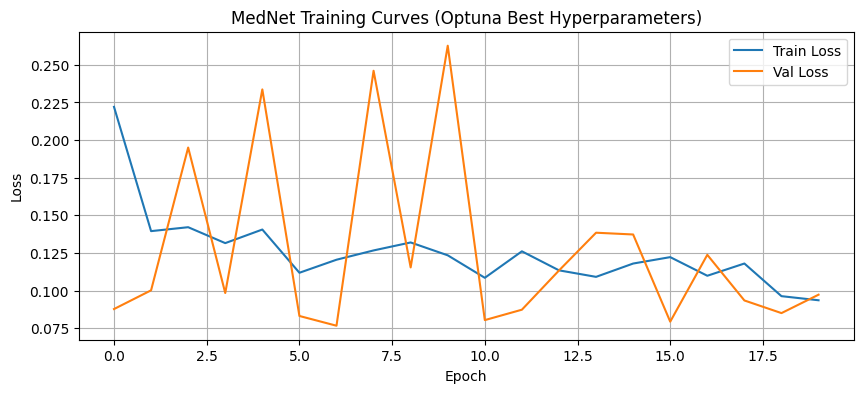


FINAL TEST SET RESULTS (Optuna-Tuned MedNet)
              precision    recall  f1-score   support

      Normal     0.8755    0.9017    0.8884       234
   Pneumonia     0.9399    0.9231    0.9314       390

    accuracy                         0.9151       624
   macro avg     0.9077    0.9124    0.9099       624
weighted avg     0.9158    0.9151    0.9153       624

ROC AUC:              0.9667
Precision:            0.9399
Recall (Sensitivity): 0.9231
Specificity:          0.9017
F1 Score:             0.9314


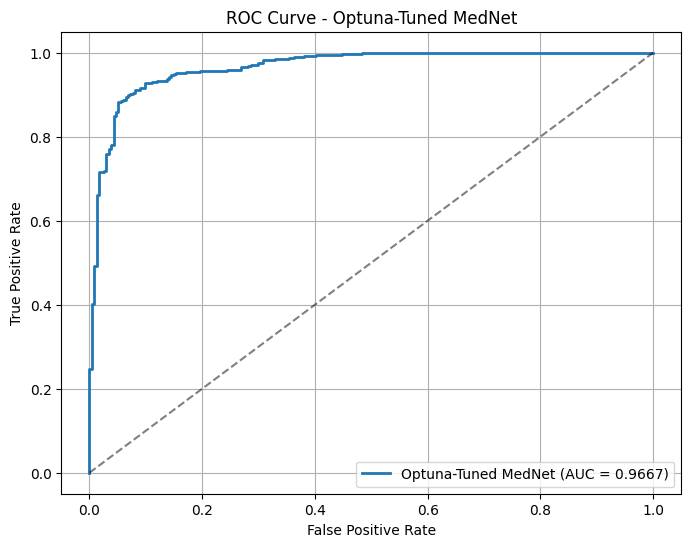

In [ ]:
# ========================================
# RETRAIN WITH BEST HYPERPARAMETERS
# ========================================

print("=" * 60)
print("RETRAINING MedNet WITH BEST HYPERPARAMETERS")
print("=" * 60)

# Extract best hyperparameters
best_params = study.best_params
print(f"\nUsing best hyperparameters from Trial #{study.best_trial.number}:")
for k, v in best_params.items():
    print(f"  {k}: {v}")

# Create data loaders with best batch size
best_batch_size = best_params['batch_size']
best_train_loader = DataLoader(
    train_dataset,
    batch_size=best_batch_size,
    sampler=get_weighted_sampler(train_dataset),
    num_workers=0
)
best_val_loader = DataLoader(val_dataset, batch_size=best_batch_size, shuffle=False, num_workers=0)
best_test_loader = DataLoader(test_dataset, batch_size=best_batch_size, shuffle=False, num_workers=0)

# Initialize best model
best_model = MedNet(
    in_channels=1,
    num_classes=2,
    dropout=best_params['dropout']
).to(device)

print(f"\nMedNet Parameters: {count_parameters(best_model):,}")

# Initialize best optimizer
if best_params['optimizer'] == 'Adam':
    best_optimizer = torch.optim.Adam(
        best_model.parameters(),
        lr=best_params['learning_rate'],
        weight_decay=best_params['weight_decay']
    )
else:
    best_optimizer = torch.optim.AdamW(
        best_model.parameters(),
        lr=best_params['learning_rate'],
        weight_decay=best_params['weight_decay']
    )

# Initialize best loss function
best_criterion = FocalLoss(
    alpha=best_params['focal_alpha'],
    gamma=best_params['focal_gamma']
)

# Scheduler
best_epochs = 20
best_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    best_optimizer, T_max=best_epochs, eta_min=1e-6
)

# Mixup settings from best params
best_use_mixup = best_params.get('use_mixup', False)
best_mixup_alpha = best_params.get('mixup_alpha', 0.2) if best_use_mixup else 0.0

# Training loop with validation tracking
train_losses = []
val_losses = []
best_val_auc = 0.0
best_model_state = None

print(f"\nTraining for {best_epochs} epochs...")
print(f"  Mixup: {'ON (alpha={:.2f})'.format(best_mixup_alpha) if best_use_mixup else 'OFF'}\n")

for epoch in range(best_epochs):
    # Training phase
    best_model.train()
    running_loss = 0.0
    for imgs, labels in best_train_loader:
        imgs = imgs.to(device)
        labels = labels.squeeze().long().to(device)

        best_optimizer.zero_grad()

        if best_use_mixup:
            mixed_imgs, labels_a, labels_b, lam = mixup_data(imgs, labels, alpha=best_mixup_alpha)
            outputs = best_model(mixed_imgs)
            loss = mixup_criterion(best_criterion, outputs, labels_a, labels_b, lam)
        else:
            outputs = best_model(imgs)
            loss = best_criterion(outputs, labels)

        loss.backward()
        best_optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(best_train_loader)
    train_losses.append(train_loss)

    # Validation phase
    best_model.eval()
    val_loss = 0.0
    val_probs_list = []
    val_labels_list = []

    with torch.no_grad():
        for imgs, labels in best_val_loader:
            imgs = imgs.to(device)
            labels_np = labels.squeeze()
            labels_dev = labels_np.long().to(device)

            outputs = best_model(imgs)
            loss = best_criterion(outputs, labels_dev)
            val_loss += loss.item()

            probs = torch.softmax(outputs, dim=1)[:, 1]
            val_probs_list.extend(probs.cpu().numpy())
            val_labels_list.extend(labels_np.numpy())

    val_loss = val_loss / len(best_val_loader)
    val_losses.append(val_loss)
    val_auc = roc_auc_score(val_labels_list, val_probs_list)

    # Save best model state
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_model_state = best_model.state_dict().copy()

    best_scheduler.step()

    print(f"Epoch {epoch+1:2d}/{best_epochs} | Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val AUC: {val_auc:.4f} | "
          f"LR: {best_scheduler.get_last_lr()[0]:.6f}")

# Load best model state
if best_model_state is not None:
    best_model.load_state_dict(best_model_state)
print(f"\nBest Validation AUC: {best_val_auc:.4f}")

# Plot training curves
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MedNet Training Curves (Optuna Best Hyperparameters)')
plt.legend()
plt.grid(True)
plt.show()

# Final evaluation on test set
best_model.eval()
all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for imgs, labels in best_test_loader:
        imgs = imgs.to(device)
        labels = labels.squeeze().numpy()
        outputs = best_model(imgs)
        probs = torch.softmax(outputs, dim=1)[:, 1]
        preds = torch.argmax(outputs, dim=1)

        all_preds.append(preds.cpu().numpy())
        all_probs.append(probs.cpu().numpy())
        all_labels.append(labels)

y_true = np.concatenate(all_labels)
y_pred = np.concatenate(all_preds)
y_probs = np.concatenate(all_probs)

# Metrics
from sklearn.metrics import classification_report
test_auc = roc_auc_score(y_true, y_probs)
test_f1 = f1_score(y_true, y_pred)
test_recall = recall_score(y_true, y_pred)
test_precision = precision_score(y_true, y_pred)
tn = np.sum((y_true == 0) & (y_pred == 0))
fp = np.sum((y_true == 0) & (y_pred == 1))
test_specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

print("\n" + "=" * 60)
print("FINAL TEST SET RESULTS (Optuna-Tuned MedNet)")
print("=" * 60)
print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia'], digits=4))
print(f"ROC AUC:              {test_auc:.4f}")
print(f"Precision:            {test_precision:.4f}")
print(f"Recall (Sensitivity): {test_recall:.4f}")
print(f"Specificity:          {test_specificity:.4f}")
print(f"F1 Score:             {test_f1:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Optuna-Tuned MedNet (AUC = {test_auc:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Optuna-Tuned MedNet')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Test-Time Augmentation (TTA)
Apply TTA to get more robust predictions by averaging across multiple augmented versions of each test image.

In [26]:
# ========================================
# 6. Evaluate with Test-Time Augmentation
# ========================================

print("\n🔄 Applying Test-Time Augmentation (TTA)...")

# Create TTA object
tta = TestTimeAugmentation(mednet_model, device, n_augments=8)

# Evaluate with TTA
all_preds_tta, all_labels_tta, all_probs_tta = [], [], []

mednet_model.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        labels = labels.squeeze().numpy()
        
        # Get TTA predictions
        probs = tta.predict(imgs)
        preds = torch.argmax(probs, dim=1)
        
        all_preds_tta.append(preds.cpu().numpy())
        all_probs_tta.append(probs[:, 1].cpu().numpy())  # Pneumonia probability
        all_labels_tta.append(labels)

y_true_tta = np.concatenate(all_labels_tta)
y_pred_tta = np.concatenate(all_preds_tta)
y_probs_tta = np.concatenate(all_probs_tta)

# Compute TTA metrics
roc_auc_tta = roc_auc_score(y_true_tta, y_probs_tta)
precision_tta = precision_score(y_true_tta, y_pred_tta)
recall_tta = recall_score(y_true_tta, y_pred_tta)
f1_tta = f1_score(y_true_tta, y_pred_tta)

tn_tta = np.sum((y_true_tta == 0) & (y_pred_tta == 0))
fp_tta = np.sum((y_true_tta == 0) & (y_pred_tta == 1))
specificity_tta = tn_tta / (tn_tta + fp_tta) if (tn_tta + fp_tta) > 0 else 0

print("\n📈 Pneumonia Detection - MedNet with TTA Results:")
print(classification_report(y_true_tta, y_pred_tta, target_names=['Normal', 'Pneumonia'], digits=4))
print(f"ROC AUC: {roc_auc_tta:.4f}")
print(f"Precision: {precision_tta:.4f}")
print(f"Recall (Sensitivity): {recall_tta:.4f}")
print(f"Specificity: {specificity_tta:.4f}")
print(f"F1 Score: {f1_tta:.4f}")

# Compare with and without TTA
print("\n📊 Comparison: Standard vs TTA Evaluation")
print(f"{'Metric':<20} {'Without TTA':<15} {'With TTA':<15} {'Improvement':<15}")
print("-" * 65)
print(f"{'ROC AUC':<20} {roc_auc_mednet:<15.4f} {roc_auc_tta:<15.4f} {roc_auc_tta - roc_auc_mednet:+.4f}")
print(f"{'Precision':<20} {precision_mednet:<15.4f} {precision_tta:<15.4f} {precision_tta - precision_mednet:+.4f}")
print(f"{'Recall':<20} {recall_mednet:<15.4f} {recall_tta:<15.4f} {recall_tta - recall_mednet:+.4f}")
print(f"{'Specificity':<20} {specificity_mednet:<15.4f} {specificity_tta:<15.4f} {specificity_tta - specificity_mednet:+.4f}")
print(f"{'F1 Score':<20} {f1_mednet:<15.4f} {f1_tta:<15.4f} {f1_tta - f1_mednet:+.4f}")


🔄 Applying Test-Time Augmentation (TTA)...



📈 Pneumonia Detection - MedNet with TTA Results:
              precision    recall  f1-score   support

      Normal     0.8253    0.9487    0.8827       234
   Pneumonia     0.9662    0.8795    0.9208       390

    accuracy                         0.9054       624
   macro avg     0.8957    0.9141    0.9018       624
weighted avg     0.9134    0.9054    0.9065       624

ROC AUC: 0.9698
Precision: 0.9662
Recall (Sensitivity): 0.8795
Specificity: 0.9487
F1 Score: 0.9208

📊 Comparison: Standard vs TTA Evaluation
Metric               Without TTA     With TTA        Improvement    
-----------------------------------------------------------------
ROC AUC              0.9632          0.9698          +0.0066
Precision            0.9574          0.9662          +0.0088
Recall               0.8641          0.8795          +0.0154
Specificity          0.9359          0.9487          +0.0128
F1 Score             0.9084          0.9208          +0.0124
